In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import boxcox1p

In [2]:
train = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
test  = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

# EDA

Посмотрим на распределение target

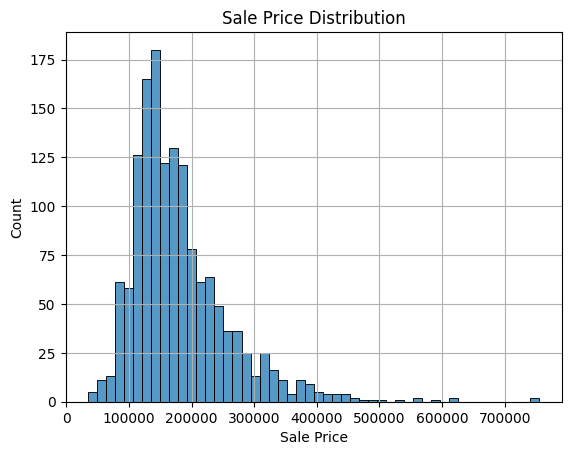

In [3]:
sns.histplot(data=train['SalePrice'], bins=50)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Посмотрим коррелограмму

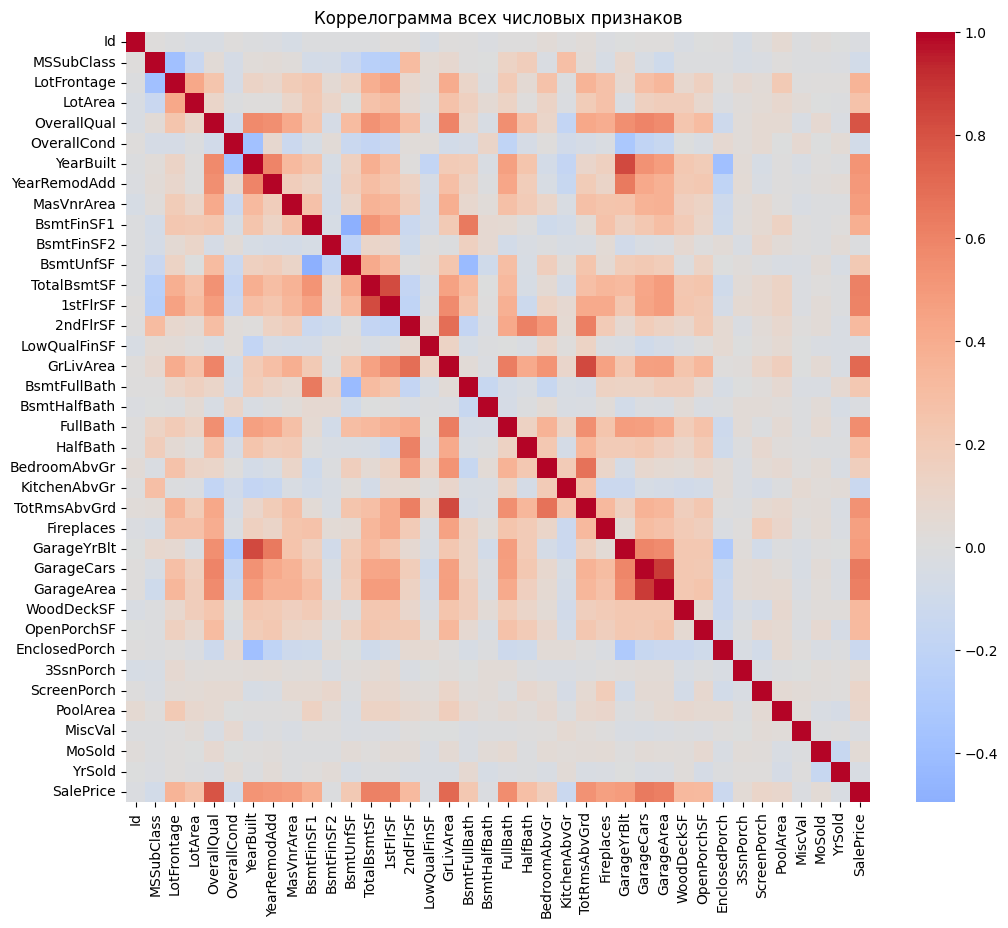

In [4]:
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(numeric_only=True), annot=False, cmap='coolwarm', center=0)
plt.title('Коррелограмма всех числовых признаков')
plt.show()

Посмотрим на признаки, которые сильно коррелируют друг с другом 

In [5]:
correlation_matrix = train.corr(numeric_only=True).abs()
unstacked = correlation_matrix.unstack()
sort = unstacked.sort_values(kind="quicksort")
sort[(sort < 1) & (sort > 0.7)]

SalePrice     GrLivArea       0.708624
GrLivArea     SalePrice       0.708624
SalePrice     OverallQual     0.790982
OverallQual   SalePrice       0.790982
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
dtype: float64

Посмотрим на признаки, сильно коррелирующие с таргетом

In [6]:
sort['SalePrice'][sort['SalePrice']>0.6]

1stFlrSF       0.605852
TotalBsmtSF    0.613581
GarageArea     0.623431
GarageCars     0.640409
GrLivArea      0.708624
OverallQual    0.790982
SalePrice      1.000000
dtype: float64

<Figure size 1200x1000 with 0 Axes>

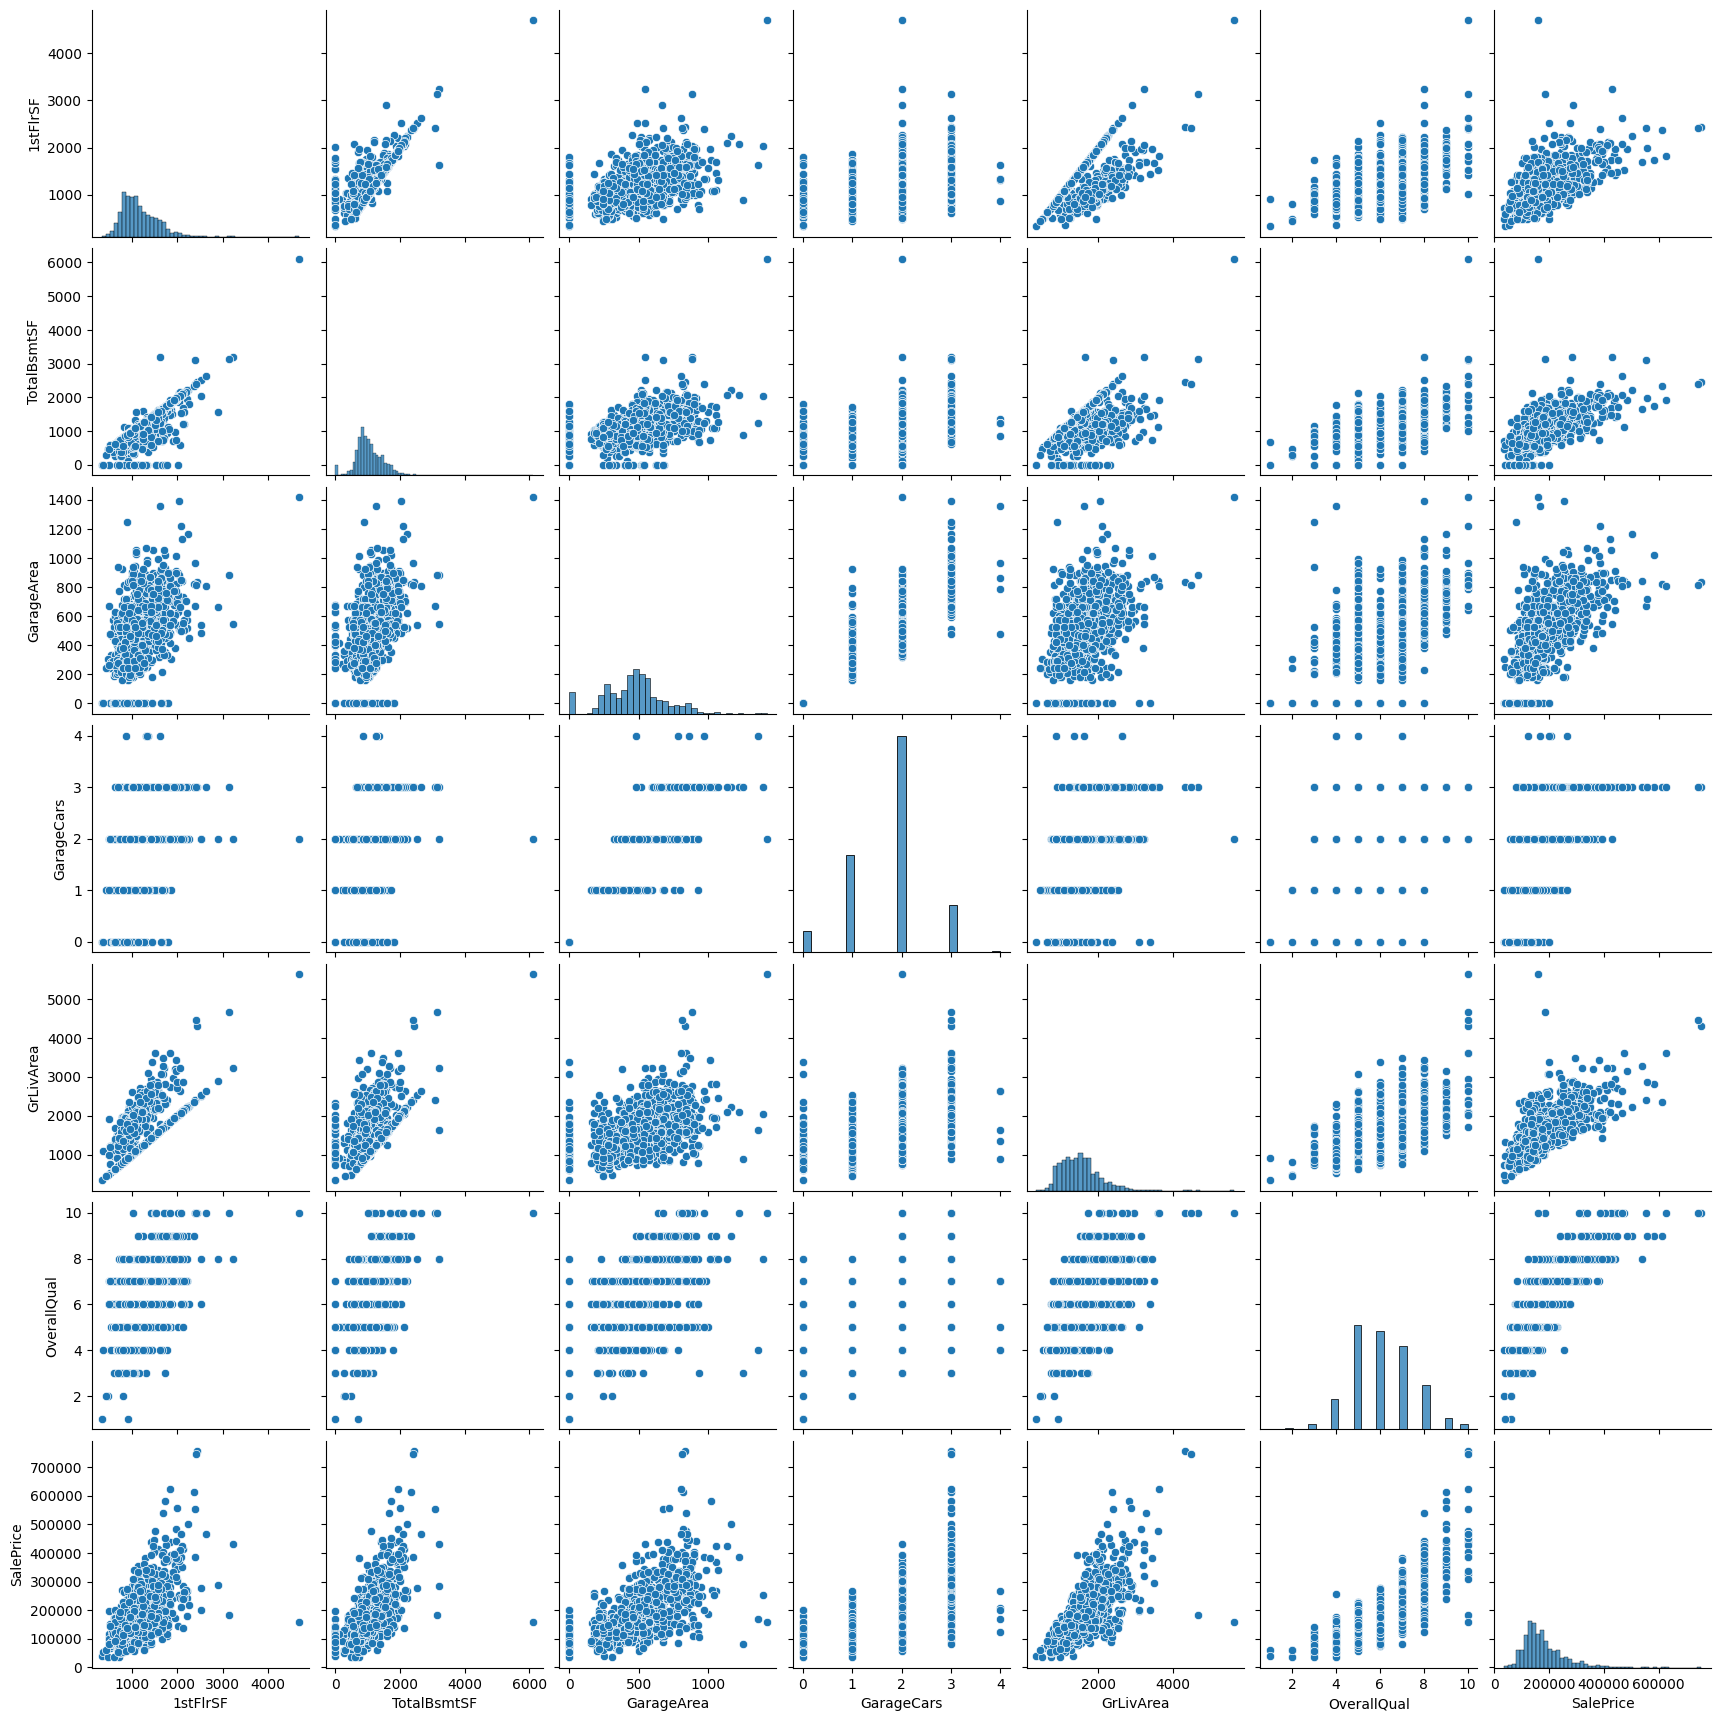

In [7]:
cols = sort['SalePrice'][sort['SalePrice']>0.6].index
plt.figure(figsize=(12, 10))
sns.pairplot(train[cols])
plt.show()

Видно, что какие-то признаки имеют выбросы, какие-то имеют неодинаковую дисперсию на всем диапазоне значений (гетероскедастичность). 

# Feature Engineering

Посмторим на одну из самых коррелированых старгетов фич - LivingArea.

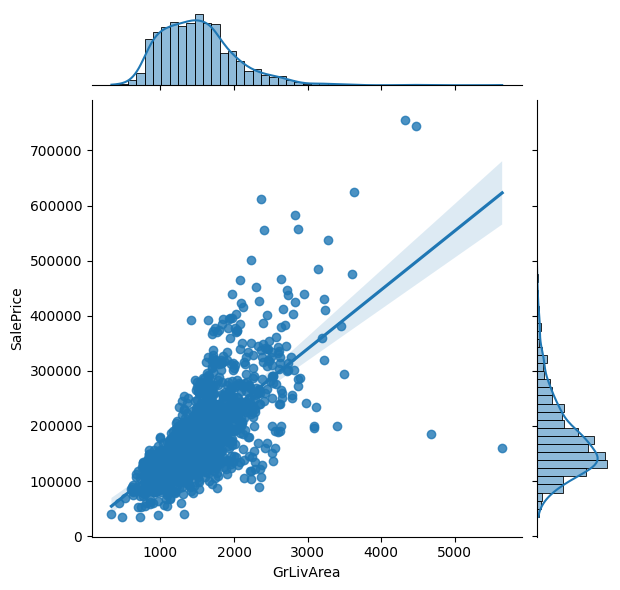

In [8]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Выбросы

Видим выбросы, которые могли бы сместить линию регрессии.  
Так же в условии сказано, что следет удалить записи с жиль площадью больше 4000.

In [9]:
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index, inplace=True)

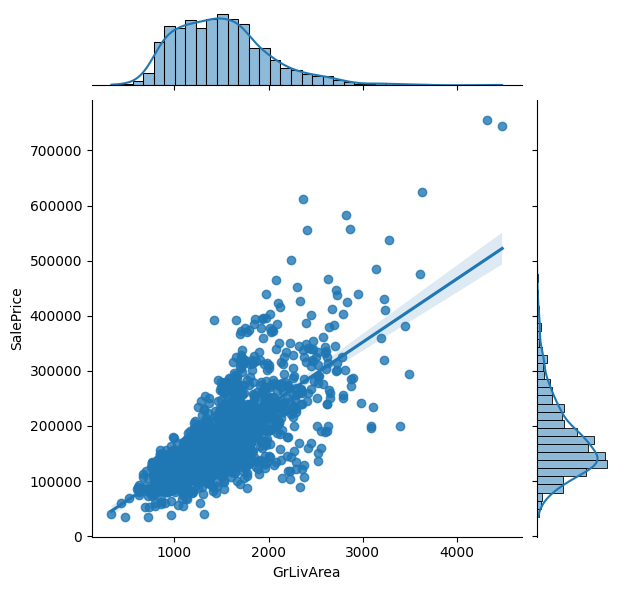

In [10]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Теперь выбросы не будут влиять на нашу модель, но опять же видно, что дисперсия непостоянна на всем диапазоне переменной.  
Чем дороже дом - тем сильнее разброс переменной

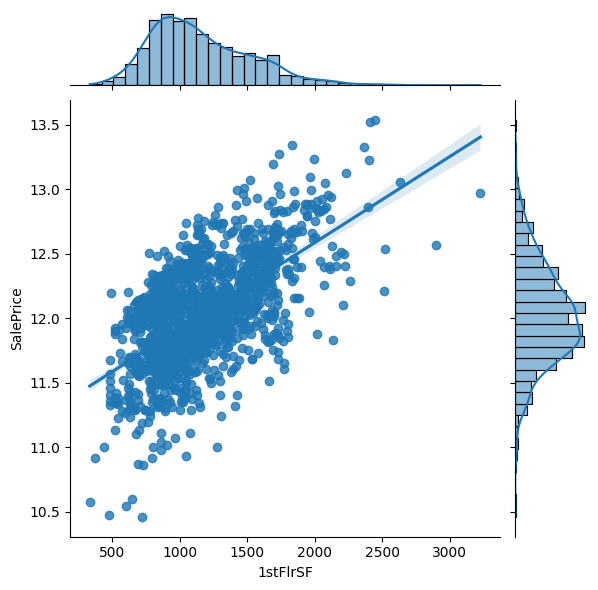

In [253]:
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

# Пропуски

Так как в тесте есть категории фичи, которые не присутствуют в трейне для этой фичи, придется объединить две выборки, поработать с ними, закодировать, а потом обранто разделить на train и test

In [12]:
all_features = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], 
                          test.loc[:,'MSSubClass':'SaleCondition']))

In [ ]:
def count_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data[missing_data['Percent']>0]

print("Number of features with missing values: {}".format(len(count_missing_data(all_features))))
count_missing_data(all_features)

Number of features with missing values: 34


,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
MasVnrType,1766,0.605417
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508
GarageQual,159,0.054508


In [14]:
def fillna_numerica_average(df):
    """ Fills the numeric features that contain 
        NaN with the average in those columns
    """
    # Get features that contain missing values
    features_with_nan = count_missing_data(df).index 
    
    # Get numeric features that contain missing values
    numeric_missing_features = df[features_with_nan].dtypes[df.dtypes != "object"].index 
    
    # Fill each missing values for the numeric features with the corresponding median
    for feature in numeric_missing_features:
        df[feature].fillna(df[feature].median(), inplace=True)
        
fillna_numerica_average(all_features)

/tmp/ipykernel_36172/1710102553.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].median(), inplace=True)
/tmp/ipykernel_36172/1710102553.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Мы заполнили пропуски numeric feature, а категориальные фичи с пропусками - удалим

In [15]:
list_missing_data = count_missing_data(all_features)
print("Number of features with missing values: {}".format(len(list_missing_data)))
print("Categorical features")
list_missing_data

Number of features with missing values: 23
Categorical features


,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
MasVnrType,1766,0.605417
FireplaceQu,1420,0.486802
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageCond,159,0.054508
GarageType,157,0.053822


In [16]:
all_features.drop(columns=list_missing_data.index, inplace=True)

# Нормализация

Применим логарифм к нашему таргету и всем фичам, которые выедут себе гетероскедастично.

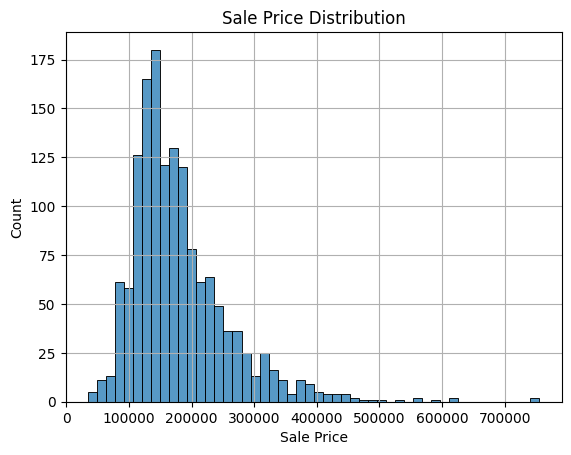

In [17]:
sns.histplot(data=train['SalePrice'], bins=50)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [18]:
train['SalePrice'] = np.log1p(train['SalePrice'])

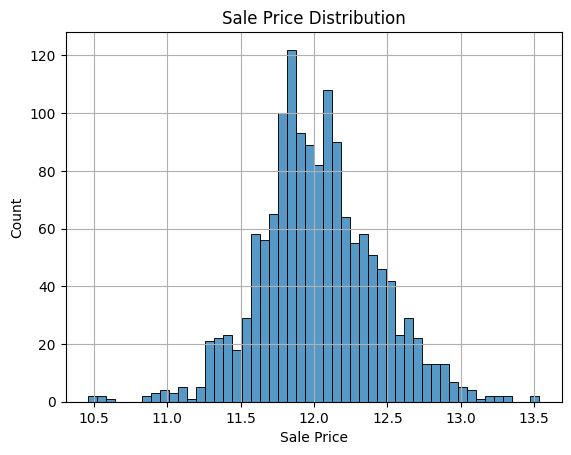

In [19]:
sns.histplot(data=train['SalePrice'], bins=50)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import skew

numeric_feature_names = all_features.dtypes[all_features.dtypes != "object"].index

skewed_features = train[numeric_feature_names].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.65].index

In [21]:
all_features[skewed_features] = boxcox1p(all_features[skewed_features], 0.15)

Закодируем наши категориальные фичи

In [22]:
all_features = pd.get_dummies(all_features, drop_first=True).astype(int)

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(all_features[numeric_feature_names])
scaled = scaler.transform(all_features[numeric_feature_names])
scaled = all_features[numeric_feature_names]


category_features_names = list(set(all_features.columns) - set(numeric_feature_names))

scaled_features = pd.DataFrame(
    data = np.hstack([scaled, all_features[category_features_names].to_numpy()]),
    columns=all_features.columns
)

In [92]:
scaled_features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,...,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,4.579362,5.290367,18.985259,6.086390,1.940007,1971.287967,1984.248200,3.007542,6.727460,1.034625,...,0.000343,0.423380,0.005142,0.032911,0.055879,0.043881,0.013027,0.002057,0.002057,0.004799
std,1.410192,0.684699,1.987993,1.406704,0.247415,30.286991,20.892257,3.886235,4.906056,2.901297,...,0.018515,0.494179,0.071537,0.178433,0.229728,0.204865,0.113410,0.045314,0.045314,0.069123
min,3.000000,3.000000,12.000000,1.000000,0.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,18.000000,5.000000,2.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,5.000000,19.000000,6.000000,2.000000,1973.000000,1993.000000,0.000000,9.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,6.000000,20.000000,7.000000,2.000000,2001.000000,2004.000000,7.000000,11.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,9.000000,35.000000,10.000000,2.000000,2010.000000,2010.000000,13.000000,16.000000,13.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [128]:
from sklearn.feature_selection import VarianceThreshold
variance = VarianceThreshold(0.01)
scaled_features_variance = variance.fit_transform(scaled_features)
scaled_features.shape
variance.get_feature_names_out

scaled_features = pd.DataFrame(
    data = scaled_features_variance,
    columns=variance.get_feature_names_out(scaled_features.columns)
)
scaled_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation_Wood,Heating_GasA,Heating_GasW,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca
0,5,5,19,7,2,2003,2003,8,11,0,...,0,0,0,0,0,0,0,0,0,0
1,3,6,19,6,2,1976,1976,0,12,0,...,0,0,0,0,0,1,0,1,0,0
2,5,5,20,7,2,2001,2002,7,10,0,...,0,0,0,0,0,0,0,0,0,0
3,5,5,19,7,2,1915,1970,0,8,0,...,0,0,0,0,0,0,0,0,0,0
4,5,6,21,8,2,2000,2000,9,10,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,7,3,14,4,2,1970,1970,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2913,7,3,14,4,2,1970,1970,0,8,0,...,0,0,0,0,0,1,0,0,0,0
2914,3,7,22,5,2,1960,1996,0,12,0,...,0,0,0,0,0,1,0,0,0,0
2915,6,5,20,5,2,1992,1992,0,9,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
y_scaler = StandardScaler()
# y = y_scaler.fit_transform(train['SalePrice'].to_numpy().reshape(-1, 1))
y = train['SalePrice'].to_numpy().reshape(-1, 1)

X_train = scaled_features[:train.shape[0]]
X_test  = scaled_features[train.shape[0]:]

Попробуем выкинуть незначимые фичи (p > 0.05)

In [151]:
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

X_sm = add_constant(X_train)

ols = OLS(y, X_sm)
ols_res = ols.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     159.4
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:29:33   Log-Likelihood:                 1102.3
No. Observations:                1458   AIC:                            -2009.
Df Residuals:                    1360   BIC:                            -1491.
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.89

In [154]:
significant_features = ols_res.pvalues[ols_res.pvalues <= 0.05].index.to_list()
significant_features.remove('const')
significant_features

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'LotConfig_CulDSac',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'Neighborhood_Blueste',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_NWAmes',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Condition1_PosN',
 'Condition2_Norm',
 'Condition2_PosN',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'RoofStyle_Gambrel',
 'RoofStyle_Mansard',
 'RoofMatl_Membran',
 'ExterQual_Gd',
 'ExterQual_TA',
 'ExterCond_Gd',
 'ExterCond_Po',
 'Foundation_Wood',
 'Heating_GasW',
 'HeatingQC_Fa',
 'HeatingQC_Gd',
 'PavedDrive_Y',
 'SaleCondition_Alloca']

In [155]:
X_sm = add_constant(X_train[significant_features])

ols = OLS(y, X_sm)
ols_res = ols.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     312.0
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:29:43   Log-Likelihood:                 1057.3
No. Observations:                1458   AIC:                            -2017.
Df Residuals:                    1409   BIC:                            -1758.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8777 

In [156]:
significant_features = ols_res.pvalues[ols_res.pvalues <= 0.05].index.to_list()
significant_features.remove('const')
significant_features

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'LotConfig_CulDSac',
 'LandSlope_Mod',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_NWAmes',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Condition2_Norm',
 'Condition2_PosN',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'RoofStyle_Gambrel',
 'RoofStyle_Mansard',
 'RoofMatl_Membran',
 'ExterQual_Gd',
 'ExterQual_TA',
 'ExterCond_Po',
 'Foundation_Wood',
 'Heating_GasW',
 'HeatingQC_Fa',
 'HeatingQC_Gd',
 'PavedDrive_Y',
 'SaleCondition_Alloca']

In [157]:
X_sm = add_constant(X_train[significant_features])

ols = OLS(y, X_sm)
ols_res = ols.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     345.8
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:29:45   Log-Likelihood:                 1050.2
No. Observations:                1458   AIC:                            -2012.
Df Residuals:                    1414   BIC:                            -1780.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8082 

In [158]:
from statsmodels.stats.diagnostic import het_white

white_test = het_white(
    ols_res.resid, X_sm
)

In [159]:
white_test

(911.1331719763535,
 0.00020135579469389344,
 1.5071099501446474,
 2.0340409010060955e-08)

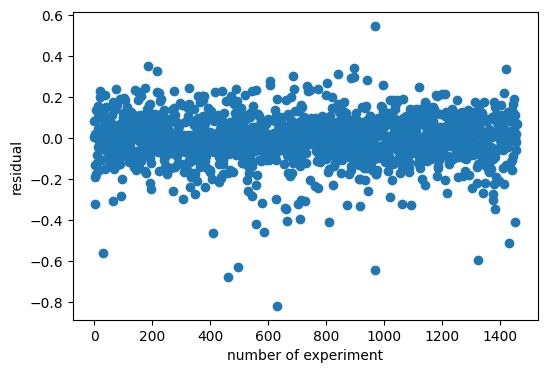

In [160]:
# Постройте график остатков от номера эксперимента
plt.figure(figsize=(6, 4))
plt.xlabel('number of experiment')
plt.ylabel('residual')
plt.scatter(x=list(range(ols_res.resid.shape[0])), y=ols_res.resid)
plt.show()


In [ ]:
y_test = pd.read_csv("./house-prices-advanced-regression-techniques/sample_submission.csv")['SalePrice']
y_test = np.log1p(y_test).to_numpy().reshape(-1, 1)

Попробуем линейные модели

In [197]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error

X = X_train[significant_features]
y = y

rmse_scorer = make_scorer(root_mean_squared_error)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

lasso = Lasso(max_iter=50000)
lasso_params = {
    'alpha': np.logspace(-4, -1, 20)
}

lasso_search = GridSearchCV(
    lasso, lasso_params, scoring=rmse_scorer, cv=cv, n_jobs=-1
)
lasso_search.fit(X, y)

enet = ElasticNet(max_iter=50000)
enet_params = {
    'alpha': np.logspace(-4, -1, 10),
    'l1_ratio': np.linspace(0, 1, 10)
}

enet_search = GridSearchCV(
    enet, enet_params, scoring=rmse_scorer, cv=cv, n_jobs=-1
)
enet_search.fit(X, y)

ridge = Ridge(max_iter=50000)
ridge_params = {
    'alpha': np.logspace(-4, 2, 20)
}

ridge_search = GridSearchCV(
    ridge, ridge_params, scoring=rmse_scorer, cv=cv, n_jobs=-1
)
ridge_search.fit(X, y)

print("\nBest Lasso:")
print(f"RMSE: {lasso_search.best_score_:.4f}")
print(f"Params: {lasso_search.best_params_}")

print("\nBest ElasticNet:")
print(f"RMSE: {enet_search.best_score_:.4f}")
print(f"Params: {enet_search.best_params_}")

print("\nBest Ridge:")
print(f"RMSE: {ridge_search.best_score_:.4f}")
print(f"Params: {ridge_search.best_params_}")


/home/nikita/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.864e+00, tolerance: 1.904e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/nikita/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.377e+00, tolerance: 1.886e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s


Best Lasso:
RMSE: 0.1959
Params: {'alpha': 0.1}

Best ElasticNet:
RMSE: 0.1959
Params: {'alpha': 0.1, 'l1_ratio': 1.0}

Best Ridge:
RMSE: 0.1304
Params: {'alpha': 100.0}


/home/nikita/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.130e+01, tolerance: 1.886e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Возьмем самую лучшую модель

In [ ]:
ridge_model = ridge_search.best_estimator_
ridge_model.fit(X_train[significant_features], y)

In [199]:
from sklearn.metrics import r2_score, \
                            mean_absolute_error, \
                            mean_squared_error, \
                            mean_absolute_percentage_error, \
                            root_mean_squared_error

def error(y_true, y_pred):
    print("r2:", r2_score(y_true, y_pred))
    print("mse:", mean_squared_error(y_true, (y_pred)))
    print("mae:", mean_absolute_error(y_true, (y_pred)))
    print("mape:", mean_absolute_percentage_error(y_true, (y_pred)))
    print("rmse:", root_mean_squared_error(y_true, (y_pred)))

Метрики на трейне

In [232]:
y_pred = ridge_model.predict(X_train[significant_features])

In [233]:
error(y, y_pred)

r2: 0.9006323535546598
mse: 0.015865114218976285
mae: 0.09021669662895325
mape: 0.007559260244635963
rmse: 0.12595679504884316


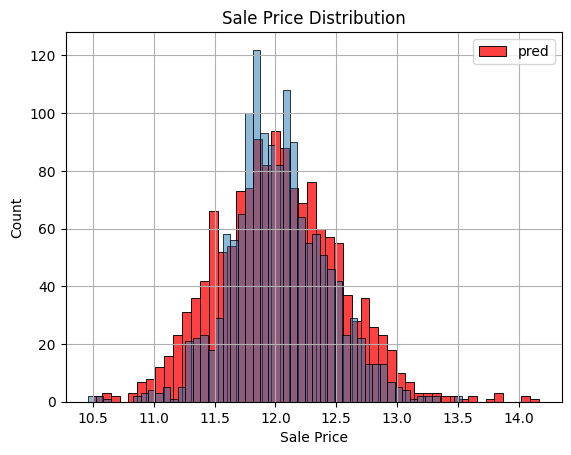

In [256]:
sns.histplot(data=y_pred, bins=50, color='red', label='pred', stat='count')
sns.histplot(data=y, bins=50, color='blue', legend='test', stat='count')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

Метрики на тесте

In [200]:
error(y_test, y_pred)

r2: -16.362664756596974
mse: 0.14070480772800123
mae: 0.30634559524491894
mape: 0.02534069163964296
rmse: 0.3751063952107471


In [201]:
best_lasso.coef_

array([ 2.45895661e-02,  7.00286035e-02,  1.21085502e-01,  1.80642715e-03,
        5.57692691e-03, -4.81622287e-03,  1.81683959e-04,  6.14030362e-03,
        7.69516621e-02,  2.42605580e-02,  2.64479603e-02, -4.60277348e-02,
        2.49708344e-02,  2.87911261e-02,  1.15635065e-04,  3.95534753e-03,
        5.73317022e-03,  1.60640198e-02, -4.18328443e-03,  1.10687212e-01,
       -2.74634169e-02, -6.00560715e-02, -3.15059920e-02,  6.63142775e-02,
       -2.51373529e-02, -4.15774787e-02,  6.47848892e-02,  3.79001154e-02,
       -1.32632433e-01,  1.29921814e-01, -3.79283849e-02, -2.69270115e-02,
       -7.18982043e-02, -7.33986119e-02,  3.90744508e-02,  8.83326936e-02,
       -4.80951656e-02, -7.76263935e-02,  8.52726804e-02,  6.98062842e-02,
       -7.18470525e-02,  3.18870454e-02,  8.69645641e-02])

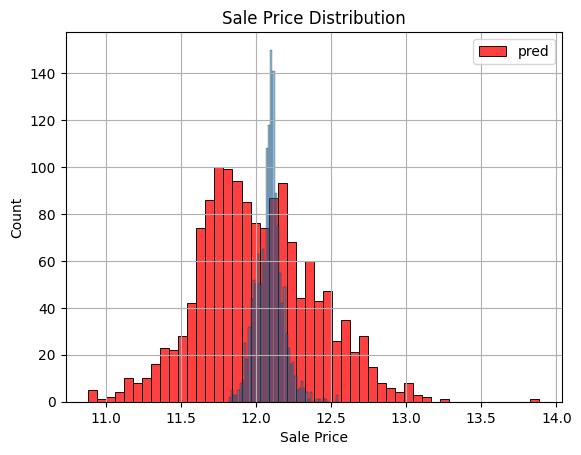

In [208]:
sns.histplot(data=y_pred, bins=50, color='red', label='pred', stat='count')
sns.histplot(data=y_test, bins=50, color='blue', legend='test', stat='count')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

Теперь попрбуем Байеса

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma]


/usr/lib/python3/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 631 draw iterations (4_000 + 2_524 draws total) took 18024 seconds.
There were 1219 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.130,0.409,-0.522,0.424,0.203,0.055,4.0,11.0,3.99
betas[0],0.069,0.161,-0.067,0.337,0.080,0.042,4.0,7.0,4.00
betas[1],0.097,0.203,-0.076,0.445,0.101,0.057,5.0,11.0,3.05
betas[2],-0.126,0.384,-0.513,0.476,0.191,0.087,4.0,11.0,3.64
betas[3],0.008,0.001,0.006,0.010,0.001,0.000,5.0,22.0,3.41
betas[4],-0.023,0.024,-0.057,0.012,0.012,0.006,4.0,11.0,4.07
betas[5],0.010,0.039,-0.039,0.065,0.019,0.008,4.0,7.0,3.42
betas[6],0.000,0.001,-0.000,0.001,0.000,0.000,4.0,12.0,3.92
betas[7],0.041,0.034,-0.001,0.092,0.017,0.008,5.0,14.0,3.65
betas[8],-0.369,0.165,-0.580,-0.182,0.082,0.020,4.0,13.0,3.26


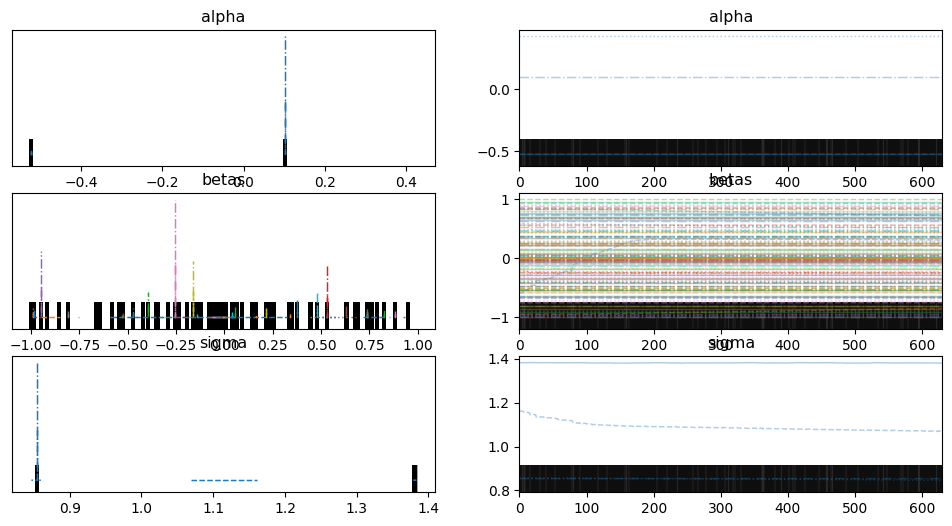

In [211]:
import pymc as pm
import arviz as az

# Байесовская модель
with pm.Model() as model:
    # Приоры для коэффициентов
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Линейная модель
    mu = alpha + pm.math.dot(X.values, betas)

    # Наблюдения
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Семплирование
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.9)

# Визуализация
az.plot_trace(trace, var_names=["alpha", "betas", "sigma"])
az.summary(trace, var_names=["alpha", "betas", "sigma"])

In [ ]:
posterior_means = trace.posterior.mean(dim=["chain", "draw"])
beta_means = posterior_means['betas'].values
alpha_mean = posterior_means['alpha'].values

Метрики на трейне

In [248]:
y_pred = X_train[significant_features] @ beta_means.T + alpha_mean

In [243]:
error(y, y_pred)

r2: -1.654504257901018
mse: 0.4238201744017804
mae: 0.5271699061997391
mape: 0.043930372850398254
rmse: 0.6510147267165163


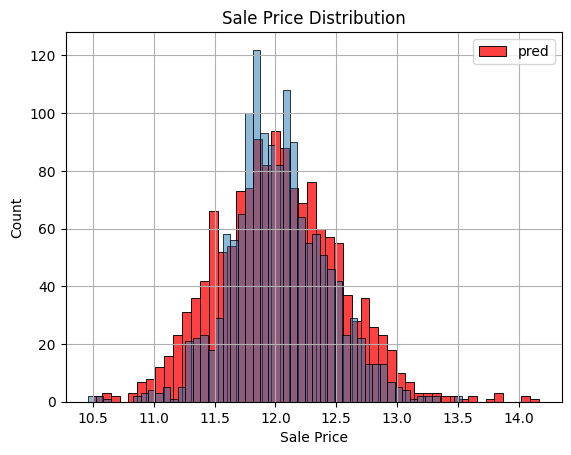

In [244]:
sns.histplot(data=y_pred, bins=50, color='red', label='pred', stat='count')
sns.histplot(data=y, bins=50, color='blue', legend='test', stat='count')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

Метрики на тесте

In [245]:
y_pred = X_test[significant_features] @ beta_means.T + alpha_mean

In [246]:
error(y_test, y_pred)

r2: -32.59496534496755
mse: 0.2722492892513231
mae: 0.41337830951816046
mape: 0.03417421600476488
rmse: 0.5217751328410766


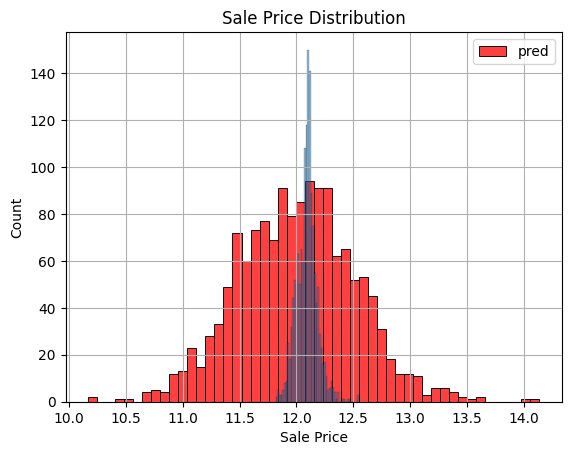

In [247]:
sns.histplot(data=y_pred, bins=50, color='red', label='pred', stat='count')
sns.histplot(data=y_test, bins=50, color='blue', legend='test', stat='count')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# Вывод

В целом, видно, что у моделей достаточно большой variance на тесте.  
Скорее всего вызвано тем, что модели линейные, а нормальность остатков не выполнялась.  
Требуется больше работы над фичами и мультиколлинеарностью.

При этом байесовский подход убрал небольшую мультимодальность в распределении ответов на тесте, в отличие от обычных моделей, которые переобучились под это.